In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, trace
import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.integrate import trapezoid
import numpy as np

from sim_utils import *
from clip import *
import matplotlib.pylab as plt

/home/frans/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def vmapped_sim_fn(sim_fn, params):
    # print(jax.tree_map(lambda x: x.shape if hasattr(x, 'shape') else None, params))
    if params['L'].ndim == 1:
        return jax.vmap(sim_fn, in_axes=0, out_axes=0)(params)
    else:
        return jax.vmap(partial(vmapped_sim_fn, sim_fn), in_axes=0, out_axes=0)(params)

In [20]:
def sim_worms(nworms, batch_size, n_frames):
    duration = 0.55
    snapshots = 10
    kpoints = 6
    box_size = 64
    with numpyro.plate('batch', batch_size, dim=-2):
        with numpyro.plate('nworms', nworms, dim=-1):
            # L = numpyro.sample('L', dist.Uniform(30, 45))
            L = numpyro.sample('L', dist.Uniform(10, 15))
            A = numpyro.sample('A', dist.Normal(1, 0.1))
            T = numpyro.sample('T', dist.Normal(0.8, 0.1))
            kw = numpyro.sample('kw', dist.Uniform(0, 2 * jnp.pi))
            ku = numpyro.sample('ku', dist.Normal(jnp.pi, 1))
            
            inc = numpyro.sample('inc', dist.Uniform(0, 2 * jnp.pi))
            dr = numpyro.sample('dr', dist.Uniform(0.2, 0.8))
            phase_1 = numpyro.sample('phase_1', dist.Uniform(0, 2 * jnp.pi))
            phase_2 = numpyro.sample('phase_2', dist.Uniform(0, 2 * jnp.pi))
            phase_3 = numpyro.sample('phase_3', dist.Normal(0, 0.1))
            alpha = numpyro.sample('alpha', dist.Normal(4, 4))

            alpha = jnp.abs(alpha + 1.0)
            half_box = box_size // 2
            x0 = numpyro.sample('x0', dist.Uniform(-1, 1))
            y0 = numpyro.sample('y0', dist.Uniform(-1, 1))
            x0 = x0 * half_box
            y0 = y0 * half_box

            params = {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}
            
            print(params['L'].shape)
            # params0 = {'L': 12.5, 'A': 0, 'T': 0.8, 'kw': jnp.pi, 'ku': 0, 'inc': jnp.pi, 'dr': 0.5, 'phase_1': jnp.pi, 'phase_2': jnp.pi, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}
            params0 = {'L': 12.5 * jnp.ones((nworms, batch_size)), 'A': 0 * jnp.ones((nworms, batch_size)), 'T': 0.8 * jnp.ones((nworms, batch_size)), 'kw': jnp.pi * jnp.ones((nworms, batch_size)), 'ku': 0 * jnp.ones((nworms, batch_size)), 'inc': jnp.pi * jnp.ones((nworms, batch_size)), 'dr': 0.5 * jnp.ones((nworms, batch_size)), 'phase_1': jnp.pi * jnp.ones((nworms, batch_size)), 'phase_2': jnp.pi * jnp.ones((nworms, batch_size)), 'phase_3': phase_3 * jnp.ones((nworms, batch_size)), 'alpha': alpha * jnp.ones((nworms, batch_size)), 'x0': x0 * jnp.ones((nworms, batch_size)), 'y0': y0 * jnp.ones((nworms, batch_size))}
            print(params0['L'].shape)

            sim_fn = partial(
                worm_simulation,
                duration=duration,
                snapshots=snapshots,
                kpoints=kpoints,
            )

            # with numpyro.plate('n_frames', n_frames, dim=-4):
            with numpyro.plate('n_frames', n_frames):
                worms = vmapped_sim_fn(sim_fn, params)
                
                worms = worms + half_box
                numpyro.deterministic('worms', worms)

            print(jnp.any(jnp.isnan(vmapped_sim_fn(sim_fn, params0))))
    return worms, x0, y0

In [21]:
# seed and trace
key, nworms, box_size = random.PRNGKey(0), 2, 64


seeded_model = seed(sim_worms, key)
tr = trace(seeded_model).get_trace(nworms=nworms, batch_size=2, n_frames=10)

(2, 2)
(2, 2)
False


In [45]:
# seed and trace
key, nworms, box_size = random.PRNGKey(0), 2, 64


seeded_model = seed(sim_worms, key)
tr = trace(seeded_model).get_trace(nworms, 20_000, 10)

In [46]:
tr['worms']['value'].shape

(20000, 2, 10, 6, 2)

In [50]:
worms = tr['worms']['value'].transpose(0, 2, 1, 3, 4)
clips = jax.vmap(convert_to_clip, in_axes=(0, None))(worms, box_size)

In [52]:
# save as npy
np.save('worms_train_20k.npy', clips)

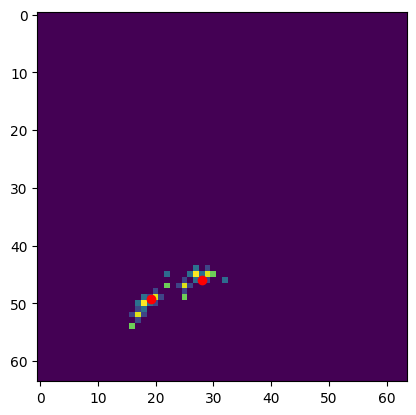

In [61]:
i = 10
frame = 7
plt.imshow(clips[i][frame])
# plot points at means
# plt.scatter(tr['x0']['value'], tr['y0']['value'])
plt.scatter(worms.mean(axis=-2)[i, frame, ..., 0], worms.mean(axis=-2)[i, frame, ..., 1], c='r')
# plt.scatter(tr['worm']['value'].mean(axis=-2)[0, ..., 0], tr['worm']['value'].mean(axis=-2)[0, ..., 1], c='r')